In [1]:
import scipy.optimize
from scipy.optimize import minimize

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys

if "../src/" not in sys.path:
    sys.path.insert(0,"../src/")

from pbcpy.formats.qepp import PP
from pbcpy.ewald import ewald

In [3]:
from pbcpy.functionals import FunctionalClass, TotalEnergyAndPotential

In [4]:
mol = PP(filepp='Al_fde_rho.pp').read()

PP_file not set in input. Can do so manually invoking Atom.local_PP
PP_file not set in input. Can do so manually invoking Atom.local_PP


In [5]:
optional_kwargs = {}
optional_kwargs["Sigma"] = 0.0
optional_kwargs["x"] = 1.0
optional_kwargs["y"] = 1.0
KE = FunctionalClass(type='KEDF',name='x_TF_y_vW',is_nonlocal=False,optional_kwargs=optional_kwargs)

In [6]:
KE.ComputeEnergyDensityPotential(rho=mol.field)

In [7]:
optional_kwargs = {}
optional_kwargs["PP_list"] = ["./Al_lda.oe01.recpot","./Al_lda.oe01.recpot"]
optional_kwargs["ions"]    = mol.ions 

IONS = FunctionalClass(type='IONS', optional_kwargs=optional_kwargs)

In [8]:
HARTREE = FunctionalClass(type='HARTREE')

In [9]:
XC = FunctionalClass(type='XC',name='LDA',is_nonlocal=False)

In [10]:
E_v_Evaluator = TotalEnergyAndPotential(rho=mol.field,
                                        KineticEnergyFunctional=KE,
                                        XCFunctional=XC,
                                        HARTREE=HARTREE,
                                        IONS=IONS)

In [11]:
phi = np.sqrt(mol.field).ravel()

In [12]:
optimization_options={}
optimization_options["disp"] = None
optimization_options["maxcor"] = 20
optimization_options["ftol"] = 1.0e-7
optimization_options["gtol"] = 1.0e-7
optimization_options["maxfun"] = 1000
optimization_options["maxiter"] = 100
optimization_options["maxls"] = 10
res = minimize(fun=E_v_Evaluator,jac=True,x0=phi,method='L-BFGS-B',options=optimization_options)

Recpot pseudopotential ./Al_lda.oe01.recpot loaded
Recpot pseudopotential ./Al_lda.oe01.recpot loaded


In [13]:
res.message

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [14]:
def plot_result(res,mol):
    from pbcpy.field import DirectField
    rho = DirectField(mol.cell,griddata_3d=np.reshape(res.x**2,np.shape(mol.field)),rank=1)
    plt.plot(mol.field[:,10,0,0],label='KS')
    plt.plot(rho[:,10,0,0],label='PBCpy')
    plt.legend()
    plt.show()
    return 0.5*np.abs(rho-mol.field), rho

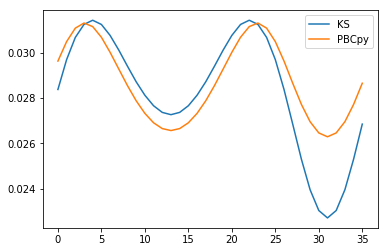

In [15]:
delta, rho = plot_result(res=res,mol=mol)

In [16]:
delta.integral()

0.26135798797828508

In [18]:
ewald(ions=mol.ions,rho=rho).energy + KE.ComputeEnergyDensityPotential(rho).energydensity.integral() + XC.ComputeEnergyDensityPotential(rho).energydensity.integral() + HARTREE.ComputeEnergyDensityPotential(rho).energydensity.integral()

-4.1303489744215511

In [20]:
E_v_Evaluator.Energy(rho=rho,ions=mol.ions)

-4.1303489744215511